# Novartis Modeling

## **Data Import and Load Packages**

In [ ]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

In [ ]:
final_df = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/final_df.csv")
final_df["launch_date"] = pd.to_datetime(final_df["launch_date"])
final_df["date"] = pd.to_datetime(final_df["date"])

In [ ]:
final_df["year"] = final_df.date.apply(lambda x: x.year)
final_df["month"] = final_df.date.apply(lambda x: x.month)

In [ ]:
final_df_v2 = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/final_df_v2.csv")
final_df_v2["launch_date"] = pd.to_datetime(final_df["launch_date"])
final_df_v2["date"] = pd.to_datetime(final_df["date"])

final_df_v2 = final_df_v2.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y,
    x4 = lambda x: 100*(x.vol_std_before_4m - x.vol_std_before_2016) / x.vol_std_before_2016,
    )
final_df_v2.x1 = final_df_v2.x1.fillna(0)
final_df_v2.x2 = final_df_v2.x2.fillna(0)
final_df_v2.x3 = final_df_v2.x3.fillna(0)
final_df_v2.x4 = final_df_v2.x4.fillna(0)

In [ ]:
# final_df_4m  = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/final_df_4m_aug.csv")
# final_df_4m["launch_date"] = pd.to_datetime(final_df_4m["launch_date"])
# final_df_4m["date"] = pd.to_datetime(final_df_4m["date"])

In [ ]:
final_df_v2.query("date >= '2019-04-01'").sort_values(['cluster_id', 'date']).head()

,country,cluster,cluster_id,date,stage_name,stage_name_lag_1,volume,business_unit,ther_area_fact,prevalence,...,vol_mean_before_4m,vol_std_before_4m,vol_mean_before_1y,vol_std_before_1y,growth_date,month_since_growth,x1,x2,x3,x4
25777,country_11,brand_57,ID_1000,2019-04-01,NaN,Forecasting,-1.0,ONE,2,-1.0,...,1.379628e+08,1.825012e+07,1.388105e+08,4.318079e+07,2014-01-01,63,32.467995,-57.735567,-0.610648,-53.543109
25778,country_11,brand_57,ID_1000,2019-05-01,NaN,Forecasting,-1.0,ONE,2,-1.0,...,1.379628e+08,1.825012e+07,1.388105e+08,4.318079e+07,2014-01-01,64,32.467995,-57.735567,-0.610648,-53.543109
25779,country_11,brand_57,ID_1000,2019-06-01,NaN,Forecasting,-1.0,ONE,2,-1.0,...,1.379628e+08,1.825012e+07,1.388105e+08,4.318079e+07,2014-01-01,65,32.467995,-57.735567,-0.610648,-53.543109
25780,country_11,brand_57,ID_1000,2019-07-01,NaN,Forecasting,-1.0,ONE,2,-1.0,...,1.379628e+08,1.825012e+07,1.388105e+08,4.318079e+07,2014-01-01,66,32.467995,-57.735567,-0.610648,-53.543109
25781,country_11,brand_57,ID_1000,2019-08-01,NaN,Forecasting,-1.0,ONE,2,-1.0,...,1.379628e+08,1.825012e+07,1.388105e+08,4.318079e+07,2014-01-01,67,32.467995,-57.735567,-0.610648,-53.543109


## **Helper Fucntions**

### Train/validtion split

In [ ]:
def train_val_split(final_df, pure_growth_perc=0, balanced_val=True):

  ''' 
  description: Extract train, val, test from final_df using 2016 as threshold
  input: final_df - the dataframe with features and labels for classification task
         pure_growth_perc - (0-1) percentage of pure growth(0) clusters added to the training set
         balanced_val - True or False, whether balance val_set or not
  output: train, val, test
  '''

  ## separate cluster according to time of transition point
  # cluster ids with transition point before 2016
  TP_before2016_id = final_df.query('stage_name!="Growth" & date<="2016-03-01"').cluster_id.unique()
  # cluster ids with transition point after 2016
  TP_after2016_id = final_df.query('stage_name=="Growth" & date=="2016-03-01"').cluster_id.unique()
  # cluster ids with transition point after 2019
  TP_after2019_id = final_df.query('stage_name=="Growth" & stage_name_lag_1=="No_Stage" & date=="2019-03-01"').cluster_id.unique()


  ## data before 2016 is for training, data in 2016-2019 is for validation, data in 2019-2022 is for testing
  # can be used in training
  TP_before2016_train_df = final_df[(final_df['cluster_id'].isin(TP_before2016_id)) & (final_df['date']<="2016-03-01")] # cluster_num=209
  TP_after2016_train_df = final_df[(final_df['cluster_id'].isin(TP_after2016_id)) & (final_df['date']<="2016-03-01")] # cluster_num=350

  # merge training set
  if pure_growth_perc>0:
    ids = TP_after2016_train_df.cluster_id.unique()
    random.seed(0)
    added_set_id = random.sample(set(ids),int(len(ids)*pure_growth_perc))
    added_set = TP_after2016_train_df[TP_after2016_train_df['cluster_id'].isin(added_set_id)]
    train_df = pd.concat([TP_before2016_train_df, added_set])
  else:
    train_df = TP_before2016_train_df

  # can be used in validation
  val_df = final_df[(final_df['cluster_id'].isin(TP_after2016_id)) & (final_df['date']>"2016-03-01") \
                                 & (final_df['date']<="2019-03-01")] # with_tp : no_tp = 4:6
  if balanced_val == True:
    val_id_withTP = list(set(TP_after2016_id)-set(TP_after2019_id)) # len=141
    val_id_noTP = [id for id in TP_after2016_id if id in TP_after2019_id] # len=209
    random.seed(0)
    val_id_noTP_chosen = random.sample(set(val_id_noTP),141)
    val_id = val_id_withTP + val_id_noTP_chosen # len=282
    val_df = final_df[(final_df['cluster_id'].isin(val_id)) & (final_df['date']>"2016-03-01") \
                                 & (final_df['date']<="2019-03-01")] # with_tp : no_tp = 5:5
    

  # used in final testing (submission)
  test_df = final_df[(final_df['cluster_id'].isin(TP_after2019_id)) & (final_df['date']>"2019-03-01")]

  return train_df, val_df, test_df
  

In [ ]:
def train_val_split_v2(final_df):

  ''' 
  description: Extract train, val from final_df by cluster id randomly (you can get test from the previous function)
               train:val=8:2
  input: final_df - the dataframe with features and labels for classification task
  output: train, val
  '''
  random.seed(0)
  
  clusterID_withTP = final_df.query('stage_name!="Growth" & date<="2019-03-01"').cluster_id.unique() # len=367
  clusterID_noTP = final_df.query('stage_name=="Growth" & date=="2019-03-01"').cluster_id.unique() # len=295

  trainID_withTP = random.sample(set(clusterID_withTP), k=int(0.8*len(clusterID_withTP))) # len=293
  trainID_noTP = random.sample(set(clusterID_noTP), k=int(0.8*len(clusterID_noTP))) # len=236
  trainID = trainID_withTP + trainID_noTP

  valID_withTP = list(set(clusterID_withTP)-set(trainID_withTP)) # len=74
  valID_noTP = list(set(clusterID_noTP)-set(trainID_noTP)) # len=59
  valID = valID_withTP + valID_noTP

  train_df = final_df[(final_df['cluster_id'].isin(trainID)) & (final_df['date']<="2019-03-01")]
  val_df = final_df[(final_df['cluster_id'].isin(valID)) & (final_df['date']<="2019-03-01")]

  return train_df, val_df

### Metrics computation functions

In [ ]:
def compute_error_validation_baseline(predicted_date):
  ''' 
  used in average baseline performance computation
  input: predicted_date is the dataframe with cluster_id and predicted_date for validiation cluters of the v1 split
  output: return error df 
          print MAE and MAPE
  '''
  val_df_transition = val_df[(val_df['stage_name']=='Maturity')].sort_values('date').groupby('cluster_id').head(1)[['cluster_id','date']]
  val_df_transition = val_df_transition.rename(columns={'date': 'transition_date'})
  val_df_compute = pd.merge(predicted_date, val_df_transition,on='cluster_id',how='left')
  

  def compute_error(transition_date, predicted_date):
    if transition_date is pd.NaT:
      if pd.to_datetime(predicted_date)<=pd.to_datetime('2019-03-01'):
        return 36
      else:
        return 0
    else:
      if pd.to_datetime(predicted_date)>pd.to_datetime('2019-03-01'):
        return 36
      elif predicted_date is pd.NaT:
        return 36
      else:
        return (abs((transition_date).year - (predicted_date).year)*12 + \
                  ((transition_date).month - (predicted_date).month))
        
  val_df_compute['absolute_error'] = val_df_compute.apply(lambda val_df_compute: compute_error(val_df_compute.transition_date, val_df_compute.predicted_date), axis=1)    
  print('mean absolute error in month: ',val_df_compute.absolute_error.mean())
  print('mean absolute error in month adjusted by predicted duration: ',val_df_compute.absolute_error.mean()/36)    
  return val_df_compute


def compute_error_validation(predicted_date):
  ''' 
  input: predicted_date is the dataframe with cluster_id and predicted_date for validiation cluters of the v1 split
  output: return error df 
          print MAE and MAPE
  '''
  val_df_transition = val_df[(val_df['stage_name']=='Maturity')].sort_values('date').groupby('cluster_id').head(1)[['cluster_id','date']]
  val_df_transition = val_df_transition.rename(columns={'date': 'transition_date'})
  val_df_compute = pd.merge(predicted_date, val_df_transition,on='cluster_id',how='left')
  

  def compute_error(transition_date, predicted_date):
    if transition_date is pd.NaT:
      if predicted_date is pd.NaT:
        return 0
      else:
        return 36
    else:
      if predicted_date is pd.NaT:
        return 36
      else:
        return (abs((transition_date).year - (predicted_date).year)*12 + \
                  ((transition_date).month - (predicted_date).month))
        
  val_df_compute['absolute_error'] = val_df_compute.apply(lambda val_df_compute: compute_error(val_df_compute.transition_date, val_df_compute.predicted_date), axis=1)    
  print('mean absolute error in month: ',val_df_compute.absolute_error.mean())
  print('mean absolute error in month adjusted by predicted duration: ',val_df_compute.absolute_error.mean()/36)    
  return val_df_compute


def compute_error_test(predicted_date, true_tp):
  ''' 
  input: predicted_date is the dataframe with cluster_id and predicted_date for test cluters of the v1 split
  output: return error df 
          print MAE and MAPE
  '''
  test_df_transition = true_tp
  test_df_compute = pd.merge(predicted_date, test_df_transition,on='cluster_id',how='left')
  

  def compute_error(transition_date, predicted_date, is_transition):
    if is_transition == 'NO':
      if predicted_date is pd.NaT:
        return 0
      else:
        return 36
    else:
      if predicted_date is pd.NaT:
        return 36
      else:
        return (abs((transition_date).year - (predicted_date).year)*12 + \
                  ((transition_date).month - (predicted_date).month))
        
  test_df_compute['absolute_error'] = test_df_compute.apply(lambda test_df_compute: compute_error(test_df_compute.transition_date, test_df_compute.predicted_date, test_df_compute.is_transition), axis=1)    
  print('mean absolute error in month: ',test_df_compute.absolute_error.mean())
  print('mean absolute error in month adjusted by predicted duration: ',test_df_compute.absolute_error.mean()/36)    
  return test_df_compute

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_validation(predicted_date):
  ''' 
  input: predicted_date is the dataframe with cluster_id and predicted_date for validiation cluters
  output: 
          plot Confusion Matrix for transition point classification
          print MAE for clusters with correct predictions
          return error df 
  '''
  val_df_transition = val_df[(val_df['stage_name']=='Maturity')].sort_values('date').groupby('cluster_id').head(1)[['cluster_id','date']]
  val_df_transition = val_df_transition.rename(columns={'date': 'transition_date'})
  val_df_compute = pd.merge(predicted_date, val_df_transition,on='cluster_id',how='left')

  def compute_error_with_transition(transition_date, predicted_date):
    if (transition_date is not pd.NaT) &  (predicted_date is not pd.NaT):
      return (abs((transition_date).year - (predicted_date).year)*12 + \
                  ((transition_date).month - (predicted_date).month))
    else:
      return pd.NaT

  def classification(date): 
     ''' 
    input: date is our predicted date and real date
    output: return '1' if there is a date, return '0' if the date is null
     '''
     if(date is pd.NaT):
       return '0'
     else:
       return '1'


  val_df_compute['absolute_error'] = val_df_compute.apply(lambda val_df_compute: compute_error_with_transition(val_df_compute.transition_date, val_df_compute.predicted_date), axis=1)    
  val_df_compute['predicted_date_class'] = val_df_compute.apply(lambda val_df_compute: classification(val_df_compute.predicted_date), axis=1)    
  val_df_compute['actual_date_class'] = val_df_compute.apply(lambda val_df_compute: classification(val_df_compute.transition_date), axis=1)  
  labels = ['without tp','with gtm tp']
  cm = confusion_matrix(val_df_compute['actual_date_class'], val_df_compute['predicted_date_class'] )
  cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
  cmd.plot()

  correct_transition = len(val_df_compute[val_df_compute['absolute_error'] == 0])
  TP = cm[0,0]
  FP = cm[0,1]
  TN = cm[1,0]
  FN = cm[1,1]
  #accuracy = (TP+ correct_transition)/ np.sum(cm).astype('float')
  accuracy = (TP+ FN)/ np.sum(cm).astype('float')

  print('accuracy (TP vs. noTP):' ,accuracy)
  print('mean absolute error in month for drugs with actual and predicted transition point: ',val_df_compute.absolute_error.mean())
  print('among {} clusters with actual and predicted transition point, {} are predicted correctly'.format(cm[1][1],correct_transition))
  print('Percentage of correct dates: {}'.format(correct_transition/cm[1][1]))
  

  return val_df_compute


def evaluate_test(predicted_date, true_tp):
  ''' 
  input: predicted_date is the dataframe with cluster_id and predicted_date for test cluters
  output: 
          plot Confusion Matrix for transition point classification
          print MAE for clusters with correct predictions
          return error df 
  '''
  test_df_transition = true_tp
  val_df_compute = pd.merge(predicted_date, test_df_transition,on='cluster_id',how='left')

  def compute_error_with_transition(transition_date, predicted_date, is_transition):
    if (is_transition == 'YES') &  (predicted_date is not pd.NaT):
      return (abs((transition_date).year - (predicted_date).year)*12 + \
                  ((transition_date).month - (predicted_date).month))
    else:
      return pd.NaT

  def classification(date): 
     ''' 
    input: date is our predicted date and real date
    output: return '1' if there is a date, return '0' if the date is null
     '''
     if(date is pd.NaT):
       return '0'
     else:
       return '1'

  def classification_1(is_transition): 
     ''' 
    input: date is our predicted date and real date
    output: return '1' if there is a date, return '0' if the date is null
     '''
     if(is_transition == 'NO'):
       return '0'
     else:
       return '1'

  val_df_compute['absolute_error'] = val_df_compute.apply(lambda val_df_compute: compute_error_with_transition(val_df_compute.transition_date, val_df_compute.predicted_date, val_df_compute.is_transition), axis=1)    
  val_df_compute['predicted_date_class'] = val_df_compute.apply(lambda val_df_compute: classification(val_df_compute.predicted_date), axis=1)    
  val_df_compute['actual_date_class'] = val_df_compute.apply(lambda val_df_compute: classification_1(val_df_compute.is_transition), axis=1)  
  labels = ['without tp','with gtm tp']
  cm = confusion_matrix(val_df_compute['actual_date_class'], val_df_compute['predicted_date_class'] )
  cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
  cmd.plot()

  correct_transition = len(val_df_compute[val_df_compute['absolute_error'] == 0])
  TP = cm[0,0]
  FP = cm[0,1]
  TN = cm[1,0]
  FN = cm[1,1]
  #accuracy = (TP+ correct_transition)/ np.sum(cm).astype('float')
  accuracy = (TP+ FN)/ np.sum(cm).astype('float')

  print('accuracy (TP vs. noTP):' ,accuracy)
  print('mean absolute error in month for drugs with actual and predicted transition point: ',val_df_compute.absolute_error.mean())
  print('among {} clusters with actual and predicted transition point, {} are predicted correctly'.format(cm[1][1],correct_transition))
  print('Percentage of correct dates: {}'.format(correct_transition/cm[1][1]))
  

  return val_df_compute

### DNN Helper Function

In [ ]:
#@title
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np

def convert_to_int(df):
  df=df.copy()
  # object to int
  #### df['business_unit'].replace(['TWO','ONE'], [2,1], inplace=True)
  cat_columns = df.select_dtypes(['category']).columns
  df[cat_columns] = df[cat_columns].astype('object')
  cat_columns = df.select_dtypes(['object']).columns
  df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x, sort=True)[0])

  # Timedelta to int
  #df['first_comp_month'] = df.first_comp_month.dt.days
  #df['last_stage_days'] = df.last_stage_days.dt.days
  # date, gx_entry_date, launch_date drop for now
  drop = {"date","gx_entry_date","launch_date"}.intersection(df.columns)
  df = df.drop(drop,axis=1)
  # boolean to int
  if "is_exclusive" in df.columns:
    df['is_exclusive'] = df.is_exclusive.astype(int)

  # impute value for nan
  if 'time_since_no_exclusivity' in df.columns:
    df.time_since_no_exclusivity = df.time_since_no_exclusivity.fillna(-120)
  if 'population' in df.columns:
    df.population = df.population.fillna(df['population'].mean())
  if 'regulatory_designations_hasany'  in df.columns:
    df.regulatory_designations_hasany = df.regulatory_designations_hasany.fillna(df['regulatory_designations_hasany'].mean())
  if 'prevalence' in df.columns:
    df.prevalence = df.prevalence.fillna(df['prevalence'].mean())

  return df
  
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

def data_balance(df):
  cnt = df.stage_name.value_counts()
  if cnt[0] == cnt[1]:
    return df
  elif cnt[0] > cnt[1]:
    low = cnt[1]
    high = cnt[0]
    label = cnt.index[1]
  else:
    low = cnt[0]
    high = cnt[1]
    label = cnt.index[0]
  diff = high - low
  pool = df.index[df.stage_name == label]

  adding = []
  for i in range(diff):
    x = random.randint(0, low - 1)
    adding.append(pool[x])
  df_add = df.loc[adding]
  return pd.concat([df, df_add], axis = 0, ignore_index=True)

# Prepare data
def cat_to_obj(final_df):
  cat_columns = final_df.select_dtypes(['category']).columns
  final_df[cat_columns] = final_df[cat_columns].astype('object')
  return final_df

# input
def input_hang(final_df, train_balance = False, val_balance = False, pure_growth_perc=0, col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date"]):
  # get train and test
  temp = final_df.reset_index().rename(columns = {"index":"index_x"})
  train_df, val_df, test_df = train_val_split(cat_to_obj(temp), pure_growth_perc)
  # balance data
  if train_balance:
    train_df = data_balance(train_df)
  if val_balance:
    val_df = data_balance(val_df)
  test_index = val_df[['index_x','cluster_id','date']]
  # drop
  
  training_set = train_df.drop(col_drop,axis=1)
  val_set = val_df.drop(col_drop,axis=1)
  # convert data type, impute NA with mean
  training = convert_to_int(training_set)
  val = convert_to_int(val_set)

  test_df_set = train_df.drop(col_drop,axis=1)
  test = convert_to_int(test_df_set)
  # shuffle
  #training = training.sample(frac =1).reset_index()
  # split x and y
  (x_train, y_train) = (training.drop(['stage_name'], axis = 1), training.stage_name)
  (x_test, y_test) = (val.drop(['stage_name'], axis = 1), val.stage_name)
  (x_val, y_val) = (test.drop(['stage_name'], axis = 1), test.stage_name)
  return training_set, val_set, x_train, y_train, x_test, y_test, test_df_set, x_val, y_val, val_df, test_df

# prediction
def prediction_hang(predictions, y_test, val_df):
  pred = np.argmax(predictions, axis = 1)
  index = y_test.index
  output = list(zip(pred, y_test))
  df = pd.DataFrame(output, columns=['predicitions', 'actual'], index=y_test.index)
  df["correct"] = df.apply(lambda row: row[0] == row[1], axis =1)
  correct = df[df.correct == True]
  incorrect = df[df.correct == False].iloc[0,:]
  # join cluster and dates
  output = pd.concat([val_df.loc[:,['cluster_id', 'date']], df], axis = 1)
  output['cumsum'] = output.groupby(['cluster_id']).predicitions.cumsum()
  output_right = output.loc[(output['cumsum'] == 1) & (output['predicitions']==1), ['cluster_id','date'] ]
  output_left = output.groupby(['cluster_id']).agg(count = ('cluster_id','count')).reset_index()
  output = output_left.merge(output_right, left_on = 'cluster_id', right_on = 'cluster_id', how = 'left').drop(['count'],axis=1).rename(columns = {'date':'predicted_date'})
  return output

# prediciton_v2
def prediction_hang_v2(predictions, y_test, val_df):
  pred = np.argmax(predictions, axis = 1)
  index = y_test.index
  output = list(zip(pred, y_test))
  df = pd.DataFrame(output, columns=['predicitions', 'actual'], index=y_test.index)
  df["correct"] = df.apply(lambda row: row[0] == row[1], axis =1)
  correct = df[df.correct == True]
  incorrect = df[df.correct == False].iloc[0,:]
  # join cluster and dates
  output = pd.concat([val_df.loc[:,['cluster_id', 'date']], df], axis = 1)
  output['cumsum'] = output.groupby(['cluster_id']).predicitions.cumsum()
  output_right = output.loc[(output['cumsum'] == 1) & (output['predicitions']==1), ['cluster_id','date'] ]
  output_left = output.groupby(['cluster_id']).agg(count = ('cluster_id','count')).reset_index()
  output = output_left.merge(output_right, left_on = 'cluster_id', right_on = 'cluster_id', how = 'left').drop(['count'],axis=1).rename(columns = {'date':'predicted_date'})
  return output

In [ ]:
def model_avg(training_set, val_set, x_train, y_train, x_test, y_test, val_df, seeds, model, n = 5, epochs = 5, batch_size = 32):
  if seeds:
    seeds = []
    for i in range(n):
      seeds.append(random.randint(0,100))

  err = []
  for i in seeds:
    tf.keras.utils.set_random_seed(i)
    history_test = mode_test.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data = (x_test, y_test))
    predictions_test = mode_test.predict(x_test)
    err_test = compute_error_validation(prediction_hang(predictions_test, y_test, val_df))
    err.append(err_test.absolute_error.mean())
  return err

In [ ]:
def model_avg(training_set, val_set, x_train, y_train, x_test, y_test, val_df, seeds, model, n = 5, epochs = 5, batch_size = 32):
  if seeds:
    seeds = []
    for i in range(n):
      seeds.append(random.randint(0,100))

  err = []
  for i in seeds:
    tf.keras.utils.set_random_seed(i)
    history_test = mode_test.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data = (x_test, y_test))
    predictions_test = mode_test.predict(x_test)
    err_test = compute_error_validation(prediction_hang(predictions_test, y_test, val_df))
    err.append(err_test.absolute_error.mean())
  return err

### Training set augment fucntion

In [ ]:
def transition_point_augment(final_df, aug_period):
    '''
    adopt from Jason's feature code
    find transition point
    Perform data augmentation with the given period n.
    For any point that has a label of 1, previous and next n rows will be augmented as 1.
    '''
    ## increase transition point
    # 1. find tp
    final_df['transition_point'] = final_df.groupby(['cluster_id','stage_name','stage_name_lag_1'])['date'].rank(method='first')
    transition = pd.DataFrame(final_df[final_df.transition_point == 1]['transition_point'])
    final_df['transition_point'] = transition
    final_df['transition_point'] = final_df['transition_point'].replace(np.nan, 0)
    final_df['transition_point'] = final_df.apply(lambda x: 0 if x.stage_name != 'Maturity' else x.transition_point,axis=1)

    # 2. Perform data augmentation with the given period n
    l = len(final_df)
    copy = final_df.copy()

    for i in range(l):
        current_row = copy.loc[i,:]
     
        try:
          if current_row.transition_point == 1:
                for j in range(1,aug_period+1):
                    prev_row = copy.loc[i-j,:]           
                    next_row = copy.loc[i+j,:]

                    if next_row.cluster_id == current_row.cluster_id:                
                        final_df.at[i+j,'transition_point'] = 1

                    if prev_row.cluster_id == current_row.cluster_id:
                        final_df.at[i-j,'transition_point'] = 1                   
        except:
            continue

    return final_df
    
#final_df = transition_point_augment(final_df, 6)
#final_df[(final_df['cluster_id']=='ID_18') & (final_df['transition_point']==1)][['transition_point','date']]

In [ ]:
def downsample_0(train_df, perc):
  '''
    downsample number of 0 in the train_df
    perc: percentage of 0 labels in the train_set
  '''

  # 1. find row indexs of 0 
  train_df = train_df.reset_index(drop=True)
  noTP_index = train_df.index[train_df['transition_point'] == 0].tolist()
  TP_index = train_df.index[train_df['transition_point'] == 1].tolist()
  # 2. random sample row index
  random.seed(0)
  new_noTP_index = random.sample(set(noTP_index),int(len(noTP_index)*perc))
  # 3. delete selected rows
  new_train_df_index = new_noTP_index + TP_index

  new_train_df = train_df.loc[new_train_df_index]
  print(f'Original number of 0s: {len(noTP_index)} after downsampling: {int(len(noTP_index)*perc)}')
  return new_train_df

### Transition point selection function

In [ ]:
def custom_prediction(validation_set,prediction,method="first",truncate=5):
    '''
    The goal of this function is to convert the prediction list into the format that can then be feed into the error function.
    The function also serves to control how we pick the transition point:
    
    By default, we pick the first predicted point as the transition point (method = "first")
    We can choose the last predicted point as the transition point (method = "last")
    We can choose the average as the transition point (method = "average")
    We can also set a threshold to determine whether we are confident that there is a transition
    '''

    val = validation_set.copy()
    val["predicted_date"] = prediction

    val_pred = val[["cluster_id","predicted_date","date"]]
    #Get only points predicted as 1
    val_pred = val_pred[val_pred.predicted_date == 1]

    #Truncate our prediction given threshold
    if truncate != 0:
        val_truncate = val_pred.groupby("cluster_id")["date"].count()
        val_truncate = val_truncate[val_truncate >= truncate ]
        truncate_indx = list(val_truncate.index)

        val_pred = val_pred[val_pred.cluster_id.isin(truncate_indx)]

    if method == "first":
        val_pred = pd.DataFrame(val_pred.groupby("cluster_id")['date'].min()).reset_index().rename({"date":"predicted_date"},axis=1)     
        val_final = pd.DataFrame({"cluster_id":val.cluster_id.unique()})
        val_final = val_final.merge(val_pred,how="left")
    elif method == "last":
        val_pred = pd.DataFrame(val_pred.groupby("cluster_id")['date'].max()).reset_index().rename({"date":"predicted_date"},axis=1)     
        val_final = pd.DataFrame({"cluster_id":val.cluster_id.unique()})
        val_final = val_final.merge(val_pred,how="left")
    elif method == "average":
        #Take average of the predicted dates
        val_pred = pd.DataFrame(val_pred.groupby("cluster_id")['date'].mean()).reset_index().rename({"date":"predicted_date"},axis=1)
        val_pred.predicted_date = val_pred.predicted_date.apply(lambda x: x.strftime("%Y-%m-01"))
        val_pred.predicted_date = pd.to_datetime(val_pred.predicted_date)
        val_final = pd.DataFrame({"cluster_id":val.cluster_id.unique()})
        val_final = val_final.merge(val_pred,how="left")

    return val_final

## **Modeling for train-val sets splitted by time**

In [ ]:
train_df, val_df, test_df = train_val_split(final_df_v2, pure_growth_perc=0, balanced_val=True)
print(len(train_df.cluster_id.unique()))
print(len(val_df.cluster_id.unique()))
print(len(test_df.cluster_id.unique()))
#print(test_df.cluster_id.unique())
#print(list(set(test_df.cluster_id.unique())-set(true_tp.cluster_id.unique())))

293
316
298


### *Average Baseline*

In [ ]:
train_df_growth = train_df[train_df['stage_name']=="Growth"]
compute_df = train_df_growth.sort_values('date').groupby("cluster_id").tail(1)[['date','launch_date','ther_area_fact']]
compute_df['length'] = (pd.DatetimeIndex(compute_df['date']).year - pd.DatetimeIndex(compute_df['launch_date']).year)*12 + (pd.DatetimeIndex(compute_df['date']).month - pd.DatetimeIndex(compute_df['launch_date']).month)
means = compute_df.groupby('ther_area_fact').mean()
#print(means)
avg = compute_df[['length']].mean()[0]
print('The average length of growth before maturity: {}'.format(avg))

val_df_compute = val_df.copy().groupby('cluster_id').head(1).reset_index()
val_df_compute['predicted_date'] = (val_df_compute['launch_date'] + pd.DateOffset(months=int(avg)))

predicted_date = val_df_compute[['cluster_id','predicted_date']]
def clean_predicted_date(date):
  if date>pd.Timestamp(2019, 3, 1) or date<=pd.Timestamp(2016, 3, 1):
    return pd.NaT
  else:
    return date
predicted_date['predicted_date'] = predicted_date['predicted_date'].apply(lambda x: clean_predicted_date(x))  

The average length of growth before maturity: 78.56313993174061


<ipython-input-18-fc393d1986f5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_date['predicted_date'] = predicted_date['predicted_date'].apply(lambda x: clean_predicted_date(x))


In [ ]:
compute_error_validation_baseline(predicted_date)

mean absolute error in month:  17.43354430379747
mean absolute error in month adjusted by predicted duration:  0.4842651195499297


,cluster_id,predicted_date,transition_date,absolute_error
0,ID_32,NaT,2017-01-01,36
1,ID_33,NaT,2018-05-01,36
2,ID_36,NaT,NaT,0
3,ID_41,NaT,NaT,0
4,ID_45,NaT,2018-05-01,36
...,...,...,...,...
311,ID_3194,NaT,2018-05-01,36
312,ID_3196,NaT,NaT,0
313,ID_3202,NaT,NaT,0
314,ID_3218,NaT,NaT,0


accuracy (TP vs. noTP): 0.5632911392405063
mean absolute error in month for drugs with actual and predicted transition point:  9.434782608695652
among 23 clusters with actual and predicted transition point, 0 are predicted correctly
Percentage of correct dates: 0.0


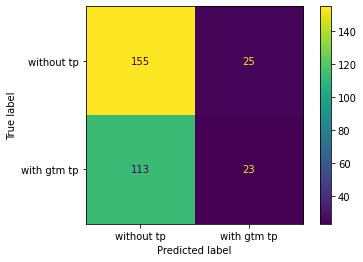

In [ ]:
c = evaluate_validation(predicted_date)

### *Baseline (No Transisiton Point for All)*

In [ ]:
predicted_date['predicted_date'] = pd.NaT
no_trans = compute_error_validation(predicted_date)

mean absolute error in month:  15.49367088607595
mean absolute error in month adjusted by predicted duration:  0.43037974683544306


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### *Transition Point Label Classification (0,1)*

In [ ]:
#Drop stage and volume columns
#Might need to convert date to three features (day,month,year)
train_df, val_df, test_df = train_val_split(final_df, pure_growth_perc=0.15)
train_df = downsample_0(train_df, 0.5)
print(len(train_df[train_df['transition_point']==1]))
print(len(train_df[train_df['transition_point']==0]))
print(len(val_df[val_df['transition_point']==1]))
print(len(val_df[val_df['transition_point']==0]))

Original number of 0s: 10800 after downsampling: 5400
2317
5400
1175
9580


In [ ]:
final_df_v2['month'] = final_df_v2.date.dt.month

In [ ]:
# train_df, val_df, test_df = train_val_split(final_df_v2)
# training_set = train_df.drop(["date","stage_name","stage_name_lag_1","stage_id_cumsum","volume","gx_entry_date","launch_date","start_date","last_stage_days"],axis=1)
# val_set = val_df.drop(["stage_name","stage_name_lag_1","stage_id_cumsum","volume","gx_entry_date","launch_date","start_date","last_stage_days"],axis=1)

# x_train = training_set.drop(["transition_point"],axis=1)
# y_train = training_set.transition_point

# x_val = val_set.drop(["transition_point"],axis=1)
# y_val = val_set.transition_point

In [ ]:
train_df, val_df, test_df = train_val_split(final_df_v2)
drop1 = ["date","stage_name",
         #"stage_name_lag_1",
         # "stage_id_cumsum", (not available any more)
         "volume","gx_entry_date","launch_date","start_date","last_stage_days","growth_date",
         #'first_comp_month',
         'last_ind_days',
         'population','prevalence',
         #'prevalence_pct', (not available any more)
         '1','2','3','4','5','6','7','8','9','10','11','12',
         'vol_mean_alltime', 'vol_std_alltime','vol_mean_before_2016', 'vol_std_before_2016', 'vol_mean_before_4m','vol_std_before_4m', 'vol_mean_before_1y', 'vol_std_before_1y'
         ]
drop2 = drop1.copy()
drop2.remove('date')

training_set = train_df.drop(drop1,axis=1)
val_set = val_df.drop(drop2, axis=1)

x_train = training_set.drop(["transition_point"],axis=1)
y_train = training_set.transition_point

x_val = val_set.drop(["transition_point"],axis=1)
y_val = val_set.transition_point

In [ ]:
x_val

,country,cluster,cluster_id,date,stage_name_lag_1,business_unit,ther_area_fact,launch_months,time_since_no_exclusivity,year,...,indication_num,comp_num,first_comp_month,is_exclusive,month_since_growth,x1,x2,x3,x4,month
805,country_0,brand_107,ID_32,2016-04-01,No_Stage,TWO,7,18,-78,2016,...,0.0,0,-1,True,16,48.382131,11.428401,18.382877,-16.361266,4
806,country_0,brand_107,ID_32,2016-05-01,No_Stage,TWO,7,19,-77,2016,...,0.0,0,-1,True,17,48.382131,11.428401,18.382877,-16.361266,5
807,country_0,brand_107,ID_32,2016-06-01,No_Stage,TWO,7,20,-76,2016,...,0.0,0,-1,True,18,48.382131,11.428401,18.382877,-16.361266,6
808,country_0,brand_107,ID_32,2016-07-01,No_Stage,TWO,7,21,-75,2016,...,0.0,0,-1,True,19,48.382131,11.428401,18.382877,-16.361266,7
809,country_0,brand_107,ID_32,2016-08-01,No_Stage,TWO,7,22,-74,2016,...,0.0,0,-1,True,20,48.382131,11.428401,18.382877,-16.361266,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80316,country_34,brand_117,ID_3221,2018-11-01,Growth,TWO,7,118,-34,2018,...,0.0,11,7640,True,45,70.682735,-2.739037,34.936709,-4.294609,11
80317,country_34,brand_117,ID_3221,2018-12-01,Growth,TWO,7,119,-33,2018,...,0.0,11,7670,True,46,70.682735,-2.739037,34.936709,-4.294609,12
80318,country_34,brand_117,ID_3221,2019-01-01,Growth,TWO,7,120,-32,2019,...,0.0,11,7701,True,47,70.682735,-2.739037,34.936709,-4.294609,1
80319,country_34,brand_117,ID_3221,2019-02-01,Growth,TWO,7,121,-31,2019,...,0.0,11,7732,True,48,70.682735,-2.739037,34.936709,-4.294609,2


#### Random Forest

In [ ]:
c_feature = ['country','cluster','cluster_id','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months','month_since_growth','x1','x2','x3','x4']

In [ ]:
from sklearn.preprocessing import StandardScaler

preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"),c_feature),
                                      (StandardScaler(),n_feature))

# rfc_pipe = make_pipeline(preprocess, GridSearchCV(RandomForestClassifier(random_state = 0,oob_score=True,warm_start=True),
#                                        param_grid = [{"n_estimators":[100,200,300],
#                                                       "max_features":["sqrt","log"],
#                                                       "class_weight":[{0:1,1:1},{0:1,1:5},{0:1,1:10}],
#                                                       "max_depth":[20,50,100]}]))
# rfc_pipe.fit(x_train,y_train)

In [ ]:
y_train.value_counts()

0.0    9278
1.0    2304
Name: transition_point, dtype: int64

In [ ]:
# grid_search_results = rfc_pipe.named_steps["gridsearchcv"]
# print(f"Best score:",grid_search_results.best_score_)
# print(f"Best parameters:",grid_search_results.best_params_)

In [ ]:
best_rfc_pipe = make_pipeline(preprocess, RandomForestClassifier( n_estimators = 200,
                                                                  max_features = 10,
                                                                  class_weight = {0:1,1:20},
                                                                  oob_score=True,
                                                                  warm_start=True ))

best_rfc_pipe.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'cluster',
                                                   'cluster_id',
                                                   'business_unit',
                                                   'ther_area_fact',
                                                   'is_exclusive', 'month',
                                                   'regulatory_designations_hasany']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['indication_num', 'comp_num',
                                                   'first_comp_month',
                                                   'launch_months',
           

In [ ]:
# import pickle
# filename = 'rf_trans_point.sav'
# pickle.dump(best_rfc_pipe, open(filename, 'wb'))
import joblib
import os
# save suing joblib
joblib.dump(best_rfc_pipe, "./rf_trans_point.joblib", compress=3)
#### load
# loaded_rf = joblib.load("./random_forest.joblib")
print(f"Random Forest: {np.round(os.path.getsize('rf_trans_point.joblib') / 1024 / 1024, 2) } MB")

Random Forest: 12.49 MB


In [ ]:
best_rfc_pipe.score(x_val,y_val)

0.8383077638307764

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


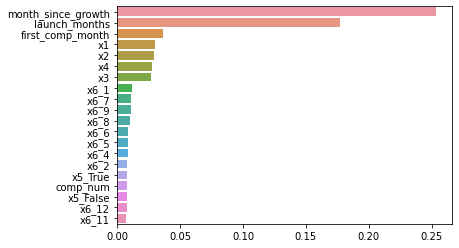

In [ ]:
ohe_f = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
f_names = ohe_f + n_feature


f_imps = zip(f_names, best_rfc_pipe.steps[1][1].feature_importances_)
feats,imps = zip(*(sorted(list(filter(lambda x:x[1] != 0, f_imps)), key = lambda x:x[1], reverse=True)))
ax = sns.barplot(list(imps[:20]),list(feats[:20]))

plt.show()

In [ ]:
print(len(f_names),\
len(best_rfc_pipe.steps[1][1].feature_importances_),\
x_val.shape[1])

428 428 21


In [ ]:
#Feature importance

# best_tree = grid_search_results.best_estimator_
# f_imps = zip(list(x_val.columns),best_tree.feature_importances_)
# feats,imps = zip(*(sorted(list(filter(lambda x:x[1] != 0, f_imps)), key = lambda x:x[1], reverse=True)))
# ax = sns.barplot(list(imps[:20]),list(feats[:20]))

# plt.show()

In [ ]:
x_val.columns

Index(['country', 'cluster', 'cluster_id', 'date', 'stage_name_lag_1',
       'business_unit', 'ther_area_fact', 'launch_months',
       'time_since_no_exclusivity', 'year', 'regulatory_designations_hasany',
       'indication_num', 'comp_num', 'first_comp_month', 'is_exclusive',
       'month_since_growth', 'x1', 'x2', 'x3', 'x4', 'month'],
      dtype='object')

In [ ]:
pred1 = best_rfc_pipe.predict(x_val.drop(columns=['date']))

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_val,pred1)

0.10036213140196584

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      9580
         1.0       0.13      0.08      0.10      1175

    accuracy                           0.84     10755
   macro avg       0.51      0.51      0.51     10755
weighted avg       0.81      0.84      0.82     10755



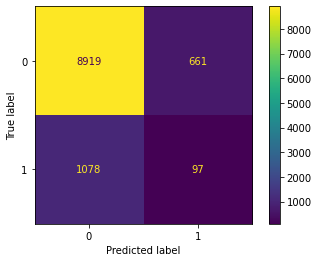

In [ ]:
conf_mat = confusion_matrix(y_val, pred1)
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['0','1'])
cmd.plot()
print(classification_report(y_val, pred1))

In [ ]:
# conf_mat = confusion_matrix(y_val, pred1)
# cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['0','1'])
# cmd.plot()
# print(classification_report(y_val, pred1))

In [ ]:
compute_error_validation(custom_prediction(val_set,pred1,method = "average"))

mean absolute error in month:  18.370253164556964
mean absolute error in month adjusted by predicted duration:  0.5102848101265823


,cluster_id,predicted_date,transition_date,absolute_error
0,ID_32,2017-01-01,2017-01-01,0
1,ID_33,NaT,2018-05-01,36
2,ID_36,NaT,NaT,0
3,ID_45,2017-12-01,2018-05-01,5
4,ID_60,NaT,2016-05-01,36
...,...,...,...,...
311,ID_3192,NaT,NaT,0
312,ID_3194,2016-07-01,2018-05-01,22
313,ID_3196,NaT,NaT,0
314,ID_3202,2017-12-01,NaT,36


accuracy (TP vs. noTP): 0.5126582278481012
mean absolute error in month for drugs with actual and predicted transition point:  9.321428571428571
among 28 clusters with actual and predicted transition point, 2 are predicted correctly
Percentage of correct dates: 0.07142857142857142


,cluster_id,predicted_date,transition_date,absolute_error,predicted_date_class,actual_date_class
0,ID_32,2017-01-01,2017-01-01,0,1,1
1,ID_33,NaT,2018-05-01,NaT,0,1
2,ID_36,NaT,NaT,NaT,0,0
3,ID_45,2017-12-01,2018-05-01,5,1,1
4,ID_60,NaT,2016-05-01,NaT,0,1
...,...,...,...,...,...,...
311,ID_3192,NaT,NaT,NaT,0,0
312,ID_3194,2016-07-01,2018-05-01,22,1,1
313,ID_3196,NaT,NaT,NaT,0,0
314,ID_3202,2017-12-01,NaT,NaT,1,0


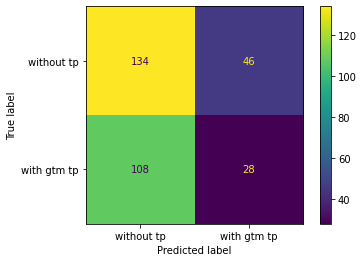

In [ ]:
evaluate_validation(custom_prediction(val_set,pred1,method = "average"))

#### Test performance

In [ ]:
true_tp = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/submission_part_one.csv")
true_tp["transition_date"] = pd.to_datetime(true_tp["transition_date"])
test_df = final_df_v2[(final_df_v2['cluster_id'].isin(true_tp.cluster_id.unique())) & (final_df_v2['date']>"2019-03-01")]
print(len(test_df.cluster_id.unique()))

226


In [ ]:
drop = ["stage_name",
         #"stage_name_lag_1",
         # "stage_id_cumsum", (not available any more)
         "volume","gx_entry_date","launch_date","start_date","last_stage_days","growth_date",
         #'first_comp_month',
         'last_ind_days',
         'population','prevalence',
         #'prevalence_pct', (not available any more)
         '1','2','3','4','5','6','7','8','9','10','11','12',
         'vol_mean_alltime', 'vol_std_alltime','vol_mean_before_2016', 'vol_std_before_2016', 'vol_mean_before_4m','vol_std_before_4m', 'vol_mean_before_1y', 'vol_std_before_1y'
         ]
test_set = test_df.drop(drop, axis=1)
x_test = test_set.drop(["transition_point"],axis=1)

In [ ]:
pred_test = best_rfc_pipe.predict(x_test.drop(columns=['date']))

In [ ]:
compute_error_test(custom_prediction(test_set,pred_test,method = "average"),true_tp)

mean absolute error in month:  27.79646017699115
mean absolute error in month adjusted by predicted duration:  0.7721238938053098


,cluster_id,predicted_date,Unnamed: 0,transition_date,is_transition,absolute_error
0,ID_35,NaT,0,2020-11-01,YES,36
1,ID_38,NaT,1,2019-12-01,YES,36
2,ID_39,NaT,2,2021-02-01,YES,36
3,ID_41,NaT,3,2020-07-01,YES,36
4,ID_62,NaT,4,2021-02-01,YES,36
...,...,...,...,...,...,...
221,ID_3117,NaT,221,2021-03-01,YES,36
222,ID_3183,NaT,222,2020-12-01,YES,36
223,ID_3187,NaT,223,2019-10-01,YES,36
224,ID_3192,NaT,224,2019-12-01,YES,36


accuracy (TP vs. noTP): 0.23008849557522124
mean absolute error in month for drugs with actual and predicted transition point:  6.875
among 8 clusters with actual and predicted transition point, 0 are predicted correctly
Percentage of correct dates: 0.0


,cluster_id,predicted_date,Unnamed: 0,transition_date,is_transition,absolute_error,predicted_date_class,actual_date_class
0,ID_35,NaT,0,2020-11-01,YES,NaT,0,1
1,ID_38,NaT,1,2019-12-01,YES,NaT,0,1
2,ID_39,NaT,2,2021-02-01,YES,NaT,0,1
3,ID_41,NaT,3,2020-07-01,YES,NaT,0,1
4,ID_62,NaT,4,2021-02-01,YES,NaT,0,1
...,...,...,...,...,...,...,...,...
221,ID_3117,NaT,221,2021-03-01,YES,NaT,0,1
222,ID_3183,NaT,222,2020-12-01,YES,NaT,0,1
223,ID_3187,NaT,223,2019-10-01,YES,NaT,0,1
224,ID_3192,NaT,224,2019-12-01,YES,NaT,0,1


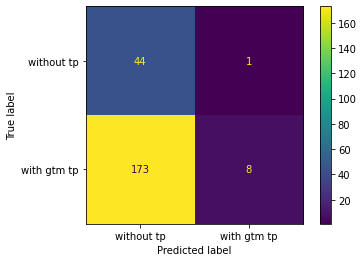

In [ ]:
evaluate_test(custom_prediction(test_set,pred_test,method = "average"),true_tp)

#### xgboost

              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87      9580
         1.0       0.16      0.23      0.19      1175

    accuracy                           0.78     10755
   macro avg       0.53      0.54      0.53     10755
weighted avg       0.82      0.78      0.80     10755



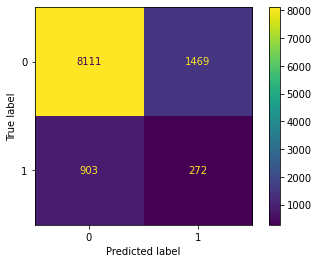

In [ ]:
import xgboost as xgb
# Init classifier
xgb_cl = xgb.XGBClassifier()

# build pipeline
c_feature = ['country','cluster','cluster_id','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months','month_since_growth','x1','x2','x3','x4']
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="ignore"),c_feature),
                                      (StandardScaler(),n_feature))
best_rfc_pipe = make_pipeline(preprocess, xgb_cl)

# Fit
best_rfc_pipe.fit(x_train,y_train)

# Predict
preds = best_rfc_pipe.predict(x_val)

# results
conf_mat = confusion_matrix(y_val, preds)
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['0','1'])
cmd.plot()
print(classification_report(y_val, preds))

In [ ]:
compute_error_validation(custom_prediction(val_set,preds,method = "average"))

mean absolute error in month:  19.879746835443036
mean absolute error in month adjusted by predicted duration:  0.5522151898734177


,cluster_id,predicted_date,transition_date,absolute_error
0,ID_32,2016-12-01,2017-01-01,1
1,ID_33,NaT,2018-05-01,36
2,ID_36,2017-07-01,NaT,36
3,ID_41,2017-05-01,NaT,36
4,ID_45,2017-10-01,2018-05-01,7
...,...,...,...,...
311,ID_3192,NaT,NaT,0
312,ID_3194,2016-07-01,2018-05-01,22
313,ID_3196,2016-08-01,NaT,36
314,ID_3218,NaT,NaT,0


accuracy (TP vs. noTP): 0.4430379746835443
mean absolute error in month for drugs with actual and predicted transition point:  9.30379746835443
among 79 clusters with actual and predicted transition point, 8 are predicted correctly
Percentage of correct dates: 0.10126582278481013


,cluster_id,predicted_date,transition_date,absolute_error,predicted_date_class,actual_date_class
0,ID_32,2016-12-01,2017-01-01,1,1,1
1,ID_33,NaT,2018-05-01,NaT,0,1
2,ID_36,2017-07-01,NaT,NaT,1,0
3,ID_41,2017-05-01,NaT,NaT,1,0
4,ID_45,2017-10-01,2018-05-01,7,1,1
...,...,...,...,...,...,...
311,ID_3192,NaT,NaT,NaT,0,0
312,ID_3194,2016-07-01,2018-05-01,22,1,1
313,ID_3196,2016-08-01,NaT,NaT,1,0
314,ID_3218,NaT,NaT,NaT,0,0


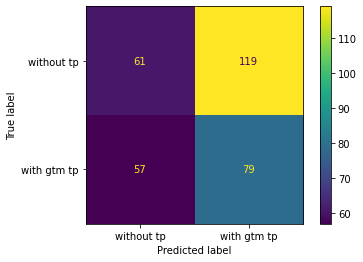

In [ ]:
evaluate_validation(custom_prediction(val_set,preds,method = "average",truncate=0))

### *Growth vs Maturity Label Classification*

In [ ]:
train_df, val_df, test_df = train_val_split(final_df_v2)
train_df = downsample_0(train_df, 0.5)
training_set = train_df.drop(["date","stage_name_lag_1","volume","gx_entry_date","launch_date","start_date","transition_point"],axis=1)
val_set = val_df.drop(["stage_name_lag_1","volume","gx_entry_date","launch_date","start_date","transition_point"],axis=1)

le = LabelEncoder()
training_set.stage_name = le.fit_transform(training_set.stage_name)
val_set.stage_name = le.transform(val_set.stage_name)

Original number of 0s: 9278 after downsampling: 4639


In [ ]:
x_train = training_set.drop(["stage_name"],axis=1)
y_train = training_set.stage_name

x_val = val_set.drop(["stage_name"],axis=1)
y_val = val_set.stage_name

In [ ]:
print(len(train_df[train_df["stage_name"]=='Growth']))
print(len(train_df[train_df["stage_name"]=='Maturity']))

3922
3021


#### Random Forest

In [ ]:
# rfc_pipe2 = make_pipeline(preprocess, GridSearchCV(RandomForestClassifier(random_state = 0,oob_score=True,warm_start=True),
#                                        param_grid = [{"n_estimators":[100,200,300],
#                                                       "max_features":[10,15,20],
#                                                       "class_weight":[{0:1,1:5},{0:1,1:10}]}]))
# rfc_pipe2.fit(x_train,y_train)

In [ ]:
# grid_search_results = rfc_pipe2.named_steps["gridsearchcv"]
# print(f"Best score:",grid_search_results.best_score_)
# print(f"Best parameters:",grid_search_results.best_params_)

In [ ]:
best_rfc_pipe2 = make_pipeline(preprocess, RandomForestClassifier(random_state = 0, 
                                  n_estimators = 300,
                                  max_features = 10,
                                  oob_score=True,
                                  warm_start=True))

best_rfc_pipe2.fit(x_train,y_train)


pred2 = best_rfc_pipe2.predict(x_val)

In [ ]:
# pred = rfc_pipe2.predict(x_val)

In [ ]:
compute_error_validation(custom_prediction(val_set,pred2,method="average",truncate=18))

In [ ]:
evaluate_validation(custom_prediction(val_set,pred2))

In [ ]:
#Final training set

final_training_set = pd.concat([train_df,val_df])
final_training_set = downsample_gm(final_training_set,0.6)

drop1 = ["date",
         #"stage_name_lag_1",
         # "stage_id_cumsum", (not available any more)
         "volume","gx_entry_date","launch_date","start_date","last_stage_days","growth_date",
         #'first_comp_month',
         'last_ind_days','transition_point',
         'population','prevalence',
         #'prevalence_pct', (not available any more)
         '1','2','3','4','5','6','7','8','9','10','11','12',
         'vol_mean_alltime', 'vol_std_alltime','vol_mean_before_2016', 'vol_std_before_2016', 'vol_mean_before_4m','vol_std_before_4m', 'vol_mean_before_1y', 'vol_std_before_1y'
         ]

final_training_set = final_training_set.drop(drop1,axis=1)

le = LabelEncoder()
final_training_set.stage_name = le.fit_transform(final_training_set.stage_name)

final_x_train = final_training_set.drop(["stage_name"],axis=1)
final_y_train = final_training_set.stage_name

Original number of 0s: 12108 after downsampling: 7264


In [ ]:
def downsample_gm(train_df, perc):
  '''
    downsample number of 0 in the train_df
    perc: percentage of 0 labels in the train_set
  '''

  # 1. find row indexs of 0 
  train_df = train_df.reset_index(drop=True)
  growth_index = train_df.index[train_df['stage_name'] == "Growth"].tolist()
  maturity_index = train_df.index[train_df['stage_name'] == "Maturity"].tolist()
  # 2. random sample row index
  random.seed(0)
  new_growth_index = random.sample(set(growth_index),int(len(growth_index)*perc))
  # 3. delete selected rows
  new_train_df_index = new_growth_index + maturity_index

  new_train_df = train_df.loc[new_train_df_index]
  print(f'Original number of 0s: {len(growth_index)} after downsampling: {int(len(growth_index)*perc)}')
  return new_train_df

In [ ]:
best_rfc_pipe_final = make_pipeline(preprocess, RandomForestClassifier(random_state = 0, 
                                  n_estimators = 300,
                                  max_features = 10,
                                  oob_score=True,
                                  warm_start=True))

best_rfc_pipe_final.fit(final_x_train,final_y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'cluster',
                                                   'cluster_id',
                                                   'business_unit',
                                                   'ther_area_fact',
                                                   'is_exclusive', 'month',
                                                   'regulatory_designations_hasany']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['indication_num', 'comp_num',
                                                   'first_comp_month',
                                                   'launch_months',
           

In [ ]:
true_tp = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/submission_part_one.csv")
true_tp["transition_date"] = pd.to_datetime(true_tp["transition_date"])
test_df = final_df_v2[(final_df_v2['cluster_id'].isin(true_tp.cluster_id.unique())) & (final_df_v2['date']>"2019-03-01")]
print(len(test_df.cluster_id.unique()))

226


In [ ]:
drop = ["transition_point",
         #"stage_name_lag_1",
         # "stage_id_cumsum", (not available any more)
         "volume","gx_entry_date","launch_date","start_date","last_stage_days","growth_date",
         #'first_comp_month',
         'last_ind_days',
         'population','prevalence',
         #'prevalence_pct', (not available any more)
         '1','2','3','4','5','6','7','8','9','10','11','12',
         'vol_mean_alltime', 'vol_std_alltime','vol_mean_before_2016', 'vol_std_before_2016', 'vol_mean_before_4m','vol_std_before_4m', 'vol_mean_before_1y', 'vol_std_before_1y'
         ]

test_set = test_df.drop(drop, axis=1)
x_test = test_set.drop(["stage_name"],axis=1)
y_test = test_set.stage_name

In [ ]:
pred_test = best_rfc_pipe_final.predict(x_test.drop(columns=['date']))

In [ ]:
df = compute_error_test(custom_prediction(test_set,pred_test,method = "average",truncate=0),true_tp)

mean absolute error in month:  22.3141592920354
mean absolute error in month adjusted by predicted duration:  0.6198377581120944


In [ ]:
df.to_csv("pred_eval.csv")

#### DNN model

###### Training Set Balanced

In [ ]:
tf.keras.utils.set_random_seed(1234)
# Set up model
model = tf.keras.models.Sequential([
    Dense(128, activation = "relu"),
    #Dropout(0.2),
    #Dense(32, activation = "relu"),
    Dropout(0.2),
    Dense(2, activation = "softmax")
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    #loss = 'sparse_categorical_accuracy',
    metrics=['accuracy']
)

#
epochs = 30
batch_size = 500

col_drop = [
            "transition_point", 'gx_entry_date', 'launch_date','date',
            "stage_name_lag_1",
            #"stage_id_cumsum",
            "volume","start_date",'cluster','growth_date',\
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            'population','prevalence',
            'regulatory_designations_hasany',
            'index_x','last_ind_days','year',
            "last_stage_days"\
            ]

training_set, val_set, x_train, y_train, x_test, y_test, test_df_set, x_val, y_val, val_df, test_df = input_hang(final_df_v2, train_balance = False, val_balance = False, col_drop=col_drop)
history1 = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data = (x_test, y_test))

337/337 [==============================] - 1s 2ms/step
x_train shape: (11582, 16)
x_test shape: (10755, 16)
maturity predicted: 6776
mean absolute error in month:  23.974683544303797
mean absolute error in month adjusted by predicted duration:  0.6659634317862166
accuracy (TP vs. noTP): 0.4525316455696203
mean absolute error in month for drugs with actual and predicted transition point:  11.824561403508772
among 114 clusters with actual and predicted transition point, 2 are predicted correctly
Percentage of correct dates: 0.017543859649122806


,cluster_id,predicted_date,transition_date,absolute_error,predicted_date_class,actual_date_class
0,ID_1003,2018-01-01,NaT,NaT,1,0
1,ID_1006,2016-04-01,NaT,NaT,1,0
2,ID_1009,2017-04-01,2018-05-01,13,1,1
3,ID_1011,2017-05-01,NaT,NaT,1,0
4,ID_1015,2017-01-01,NaT,NaT,1,0
...,...,...,...,...,...,...
311,ID_952,2017-06-01,NaT,NaT,1,0
312,ID_96,2016-04-01,NaT,NaT,1,0
313,ID_996,2016-04-01,NaT,NaT,1,0
314,ID_997,NaT,NaT,NaT,0,0


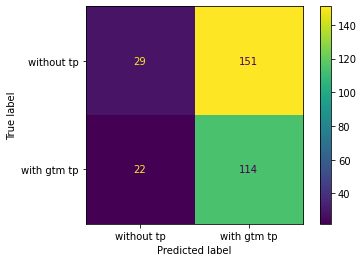

In [ ]:
predictions1 = model.predict(x_test)
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'maturity predicted: {sum(np.argmax(predictions1, axis=1))}')
err1 = compute_error_validation(prediction_hang(predictions1, y_test, val_df))
evaluate_validation(err1.loc[:,['cluster_id','predicted_date']])

###### Test Performance DNN

In [ ]:
def x_1_to_4(final_df_v2):
  output = final_df_v2.copy()
  output = output.drop(columns = ['vol_mean_before_2016', 'vol_std_before_2016', 'vol_mean_before_4m','vol_std_before_4m', 'vol_mean_before_1y', 'vol_std_before_1y','x1','x2','x3','x4'])
  output_right = output.query('date<="2019-03-01"').groupby(['cluster_id']).agg(vol_mean_before_2016 = ('volume', np.mean), vol_std_before_2016 = ('volume', np.std)).reset_index()
  output = output.merge(output_right, how = 'left', on = 'cluster_id')
  #
  output_right = output.query('date<="2019-03-01" & date >= "2018-11-01" ').groupby(['cluster_id']).agg(vol_mean_before_4m = ('volume', np.mean), vol_std_before_4m = ('volume', np.std)).reset_index()
  output = output.merge(output_right, how = 'left', on = 'cluster_id')
  #
  output_right = output.query('date<="2019-03-01" & date >= "2018-03-01" ').groupby(['cluster_id']).agg(vol_mean_before_1y = ('volume', np.mean), vol_std_before_1y = ('volume', np.std)).reset_index()
  output = output.merge(output_right, how = 'left', on = 'cluster_id')
  output = output.assign(
    x1 = lambda x: 100* x.vol_mean_alltime / x.vol_std_alltime ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/ x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y,
    x4 = lambda x: 100*(x.vol_std_before_4m - x.vol_std_before_2016) / x.vol_std_before_2016,
    )
  output.x1 = output.x1.fillna(0)
  output.x2 = output.x2.fillna(0)
  output.x3 = output.x3.fillna(0)
  output.x4 = output.x4.fillna(0)
  return output

In [ ]:
training_set, val_set, x_train, y_train, x_test, y_test, test_df_set, x_val, y_val, val_df, test_df = input_hang(x_1_to_4(final_df_v2), train_balance = False, val_balance = False, col_drop=col_drop)
test_df = test_df[(test_df['cluster_id'].isin(true_tp.cluster_id.unique())) & (test_df['date']>"2019-03-01")]
test_df_set = test_df.drop(set(col_drop).intersection(test_df),axis=1)
test = convert_to_int(test_df_set)
(x_val, y_val) = (test.drop(['stage_name'], axis = 1), test.stage_name)

240/240 [==============================] - 0s 2ms/step
x_train shape: (11582, 16)
x_test shape: (7659, 16)
maturity predicted: 7413
mean absolute error in month:  35.82608695652174
mean absolute error in month adjusted by predicted duration:  0.995169082125604
accuracy (TP vs. noTP): 0.004830917874396135
mean absolute error in month for drugs with actual and predicted transition point:  NaT
among 0 clusters with actual and predicted transition point, 0 are predicted correctly
Percentage of correct dates: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars


,cluster_id,predicted_date,transition_date,absolute_error,predicted_date_class,actual_date_class
0,ID_1004,2019-04-01,NaT,NaT,1,0
1,ID_1058,2019-04-01,NaT,NaT,1,0
2,ID_1069,2019-04-01,NaT,NaT,1,0
3,ID_1073,2019-04-01,NaT,NaT,1,0
4,ID_1074,2019-04-01,NaT,NaT,1,0
...,...,...,...,...,...,...
202,ID_919,2019-04-01,NaT,NaT,1,0
203,ID_925,2019-04-01,NaT,NaT,1,0
204,ID_952,2019-04-01,NaT,NaT,1,0
205,ID_96,2019-04-01,NaT,NaT,1,0


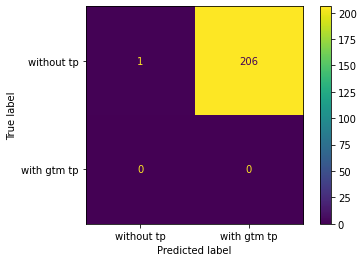

In [ ]:
predictions = model.predict(x_val)
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_val.shape}')
print(f'maturity predicted: {sum(np.argmax(predictions, axis=1))}')
err1 = compute_error_validation(prediction_hang(predictions, y_val, test_df))
evaluate_validation(err1.loc[:,['cluster_id','predicted_date']])

###### Training Set Not Balanced

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      #Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 30
batch_size = 200

col_drop = col_drop = [
            "transition_point",
            #"stage_name_lag_1",
            #"stage_id_cumsum",
            "volume","start_date",'cluster',\
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            'population','prevalence','growth_date',
            #'prevalence_pct',
            'regulatory_designations_hasany',
            'index_x','last_ind_days','year',
            #'x1','x2','x3'\
            "last_stage_days"\
            ]

drop1 = ["date",
         #"stage_name",
         "stage_name_lag_1",
         # "stage_id_cumsum", (not available any more)
         "volume","gx_entry_date","launch_date","start_date","last_stage_days","growth_date",
         #'first_comp_month',
         'last_ind_days',
         'population','prevalence',
         #'prevalence_pct', (not available any more)
         '1','2','3','4','5','6','7','8','9','10','11','12',
         'vol_mean_alltime', 'vol_std_alltime','vol_mean_before_2016', 'vol_std_before_2016', 'vol_mean_before_4m','vol_std_before_4m', 'vol_mean_before_1y', 'vol_std_before_1y'
         ]

pure_growth_perc = 1
training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df_v2, train_balance = False, val_balance = False, col_drop = col_drop, pure_growth_perc=pure_growth_perc)

n = 10

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
final_df.columns

## **Modeling for train-val set splitted by cluster_id**

In [ ]:
train_df, val_df= train_val_split_v2(final_df)
print(len(train_df.cluster_id.unique()))
print(len(val_df.cluster_id.unique()))

### Average Baseline

In [ ]:
train_df, val_df = train_val_split_v2(final_df)
train_df_growth = train_df[train_df['stage_name']=="Growth"]
compute_df = train_df_growth.sort_values('date').groupby("cluster_id").tail(1)[['date','launch_date','ther_area_fact']]
compute_df['length'] = (pd.DatetimeIndex(compute_df['date']).year - pd.DatetimeIndex(compute_df['launch_date']).year)*12 + (pd.DatetimeIndex(compute_df['date']).month - pd.DatetimeIndex(compute_df['launch_date']).month)
means = compute_df.groupby('ther_area_fact').mean()
#print(means)
avg = compute_df[['length']].mean()[0]
print('The average length of growth before maturity: {}'.format(avg))

val_df_compute = val_df.copy().groupby('cluster_id').head(1)
val_df_compute['predicted_date'] = (val_df_compute['launch_date'] + pd.DateOffset(months=int(avg)))
predicted_date = val_df_compute[['cluster_id','predicted_date']]

In [ ]:
compute_error_validation(predicted_date)

In [ ]:
c = evaluate_validation(predicted_date)

In [ ]:
c[c['absolute_error'] == 0]

### Transition Point Label Classification (0,1)

In [ ]:
train2,val2 = train_val_split_v2(final_df_v2)

train2 = downsample_0(train2, 0.5)

In [ ]:
training_set2 = train2.drop(["date","stage_name","stage_name_lag_1","stage_id_cumsum","volume","gx_entry_date","launch_date","start_date"],axis=1)
val_set2 = val2.drop(["stage_name","stage_name_lag_1","stage_id_cumsum","volume","gx_entry_date","launch_date","start_date"],axis=1)

In [ ]:
x_train2 = training_set2.drop(["transition_point"],axis=1)
y_train2 = training_set2.transition_point

x_val2 = val_set2.drop(["transition_point"],axis=1)
y_val2 = val_set2.transition_point

##### random forest


In [ ]:
rfc_pipe3 = make_pipeline(preprocess, RandomForestClassifier(random_state = 0, 
                                  n_estimators = 300,
                                  max_features = 10,
                                  #class_weight = {0:1,1:90},
                                  oob_score=True,
                                  warm_start=True))

rfc_pipe3.fit(x_train2,y_train2)

In [ ]:
pred = rfc_pipe3.predict(x_val2)

In [ ]:
rfc_pipe3.score(x_val2,y_val2)

In [ ]:
compute_error_validation(custom_prediction(val_set2,pred,truncate=0))

In [ ]:
evaluate_validation(custom_prediction(val_set2,pred,truncate=0))

### Growth vs Maturity Label Classification

## **Model Evaluation**

In [ ]:
predictions1 = model.predict(x_test)
err1 = compute_error_validation(prediction_hang(predictions1, y_test, val_df))
err1_1 = evaluate_validation(err1.loc[:,['cluster_id','predicted_date']])

In [ ]:
predictions2 = mode2.predict(x_test)
err2 = compute_error_validation(prediction_hang(predictions2, y_test, val_df))
err2_2 = evaluate_validation(err2.loc[:,['cluster_id','predicted_date']])

## **Working Code**

### Working Code (Hang)

#### Adding new features

In [ ]:
final_df = transition_point_augment(final_df_v2, 6)

In [ ]:
final_df['month'] = final_df.date.dt.month
final_df['last_ind_days'] = final_df.last_ind_days.astype(int)

In [ ]:
final_df['last_ind_days']

In [ ]:
#Drop stage and volume columns
#Might need to convert date to three features (day,month,year)
train_df, val_df, test_df = train_val_split(final_df, pure_growth_perc=0.15)
train_df = downsample_0(train_df, 0.5)
print(len(train_df[train_df['transition_point']==1]))
print(len(train_df[train_df['transition_point']==0]))
print(len(val_df[val_df['transition_point']==1]))
print(len(val_df[val_df['transition_point']==0]))

In [ ]:
c_feature = ['country','cluster','cluster_id','business_unit','ther_area_fact','prevalence_pct','launch_months', 'month']

In [ ]:
drop1 = ["date","stage_name","stage_name_lag_1","stage_id_cumsum","volume","gx_entry_date","launch_date","start_date","last_stage_days","growth_date",
         'first_comp_month','last_ind_days',
         'population','prevalence','regulatory_designations_hasany',
         '1','2','3','4','5','6','7','8','9','10','11','12',
         'vol_mean_alltime', 'vol_std_alltime','vol_mean_before_2016', 'vol_std_before_2016', 'vol_mean_before_4m','vol_std_before_4m', 'vol_mean_before_1y', 'vol_std_before_1y'
         ]
drop2 = drop1.copy()
drop2.remove('date')

training_set = train_df.drop(drop1,axis=1)
val_set = val_df.drop(drop2, axis=1)
x_train = training_set.drop(["transition_point"],axis=1)
y_train = training_set.transition_point

x_val = val_set.drop(["transition_point"],axis=1)
y_val = val_set.transition_point

In [ ]:
a=[]
for i in training_set.columns:
  if i not in c_feature:
    a.append(i)
a

In [ ]:
training_set.loc[:,a].info()

In [ ]:
preprocess = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), c_feature),
    remainder='passthrough'
    )
p = preprocess.fit(training_set)
ts = p.transform(training_set)
a = ts.toarray()
a.shape

In [ ]:
best_rfc_pipe = make_pipeline(preprocess, RandomForestClassifier(random_state = 0,
                                                                    n_estimators = 200,
                                                                    max_features = 10,
                                                                    class_weight = {0:1,1:20},
                                                                    oob_score=True,
                                                                    warm_start=True))

best_rfc_pipe.fit(x_train,y_train)

In [ ]:
pred1 = best_rfc_pipe.predict(x_val)
#
conf_mat = confusion_matrix(y_val, pred1)
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['0','1'])
cmd.plot()
print(classification_report(y_val, pred1))

In [ ]:
6600+415

In [ ]:
6898+350

In [ ]:
evaluate_validation(x)

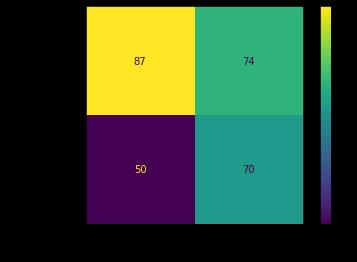

In [ ]:
#
x = custom_prediction(val_set,pred1,method = "average")
#x['predicted_date'] = pd.NaT
compute_error_validation(x)

In [ ]:
variables = []
for i in c_feature:
  n = len(training_set.loc[:,i].unique())
  variables.extend([i] * n)
print(len(variables))

In [ ]:
len(best_rfc_pipe.steps[1][1].feature_importances_)

In [ ]:
c_feature

In [ ]:
training_set.columns

In [ ]:
f_imps = zip(best_rfc_pipe.steps[0][1].feature_names_in_, best_rfc_pipe.steps[1][1].feature_importances_)
feats,imps = zip(*(sorted(list(filter(lambda x:x[1] != 0, f_imps)), key = lambda x:x[1], reverse=True)))
ax = sns.barplot(list(imps[:20]),list(feats[:20]))

plt.show()

In [ ]:
list(x_val.columns)

#### DNN

In [ ]:
def prediction_hang_v2(predictions, y_test, val_df):
  pred = np.argmax(predictions, axis = 1)
  index = y_test.index
  output = list(zip(pred, y_test))
  df = pd.DataFrame(output, columns=['predicitions', 'actual'], index=y_test.index)
  df["correct"] = df.apply(lambda row: row[0] == row[1], axis =1)
  correct = df[df.correct == True]
  incorrect = df[df.correct == False].iloc[0,:]
  # join cluster and dates
  output = pd.concat([val_df.loc[:,['cluster_id', 'date']], df], axis = 1)
  output['cumsum'] = output.groupby(['cluster_id']).predicitions.cumsum()
  output_right = output.loc[(output['cumsum'] == 1) & (output['predicitions']==1), ['cluster_id','date'] ]
  output_left = output.groupby(['cluster_id']).agg(count = ('cluster_id','count')).reset_index()
  output = output_left.merge(output_right, left_on = 'cluster_id', right_on = 'cluster_id', how = 'left').drop(['count'],axis=1).rename(columns = {'date':'predicted_date'})
  return output

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

col_drop = col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            'cluster',\
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'population','prevalence','growth_date','prevalence_pct','regulatory_designations_hasany',
            #'x1','x2','x3'\
            "last_stage_days"\
            ]

pure_growth_perc = 1
training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(input, train_balance = False, val_balance = False, col_drop = col_drop, pure_growth_perc=pure_growth_perc)

epochs = 30
batch_size = 200

history_test = mode_test.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data = (x_test, y_test))
predictions_test = mode_test.predict(x_test)
err1 = compute_error_validation(prediction_hang(predictions_test, y_test, val_df))
err1_1 = evaluate_validation(err1.loc[:,['cluster_id','predicted_date']])

print(f'training set growth pct: {1 - y_train.sum() / y_train.shape[0]}')
print(f'test set growth pct:{1 - y_test.sum() / y_test.shape[0]}')
print(f'prediction growth pct: {1 - np.argmax(predictions_test, axis = 1).sum() / y_test.shape[0]}')
print(f"mean accurary: {np.mean(history_test.history['accuracy'])}")

In [ ]:
pred = np.argmax(predictions_test, axis = 1)
index = y_test.index
output = list(zip(pred, y_test))
df = pd.DataFrame(output, columns=['predicitions', 'actual'], index=y_test.index)
df["correct"] = df.apply(lambda row: row[0] == row[1], axis =1)
correct = df[df.correct == True]
incorrect = df[df.correct == False].iloc[0,:]
# join cluster and dates
output = pd.concat([val_df.loc[:,['cluster_id', 'date']], df], axis = 1)
output['cumsum'] = output.groupby(['cluster_id']).predicitions.cumsum()
output_right = output.loc[(output['cumsum'] == 3) & (output['predicitions']==1), ['cluster_id','date'] ]
output_left = output.groupby(['cluster_id']).agg(count = ('cluster_id','count')).reset_index()

In [ ]:
output = output_left.merge(output_right, left_on = 'cluster_id', right_on = 'cluster_id', how = 'left').drop(['count'],axis=1).rename(columns = {'date':'predicted_date'})
err1 = compute_error_validation(output)
err1_1 = evaluate_validation(err1.loc[:,['cluster_id','predicted_date']])

In [ ]:
output.head(200)

In [ ]:
plot(history_test)

With leak information. 

In [ ]:
#@title
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 30
batch_size = 200

col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            #'cluster',\
            #'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'x1','x2','x3'\
            #"last_stage_days"\
            ]

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(
    input, 
    train_balance = False, 
    val_balance = False, 
    col_drop = col_drop
    )

n = 5

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 30
batch_size = 200

col_drop = col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            'cluster',\
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            'population','prevalence','growth_date','prevalence_pct','regulatory_designations_hasany',
            #'x1','x2','x3'\
            "last_stage_days"\
            ]

pure_growth_perc = 1
training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(input, train_balance = True, val_balance = False, col_drop = col_drop, pure_growth_perc=pure_growth_perc)

n = 5

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
x_train.head()

In [ ]:
x_train.columns

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 30
batch_size = 200

col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            #'cluster',\
            #'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'x1','x2','x3'\
            #"month_since_growth",
            "last_stage_days"\
            ]
input = final_df_v2.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y ,
                   )
input.x1 = input.x1.fillna(0)
input.x2 = input.x2.fillna(0)
input.x3 = input.x3.fillna(0)

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(
    input, 
    train_balance = False, 
    val_balance = False, 
    col_drop = col_drop
    )

n = 5

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
input.month_since_growth.value_counts()

#### Hide

In [ ]:
test_df = test_df[(test_df['cluster_id'].isin(true_tp.cluster_id.unique())) & (test_df['date']>"2019-03-01")]
test_df_set = test_df.drop(set(col_drop).intersection(test_df),axis=1)
test = convert_to_int(test_df_set)
(x_val, y_val) = (test.drop(['stage_name'], axis = 1), test.stage_name)

In [ ]:
def x_1_to_4(final_df_v2):
  output = final_df_v2.copy()
  output = output.drop(columns = ['vol_mean_before_2016', 'vol_std_before_2016', 'vol_mean_before_4m','vol_std_before_4m', 'vol_mean_before_1y', 'vol_std_before_1y','x1','x2','x3','x4'])
  output_right = output.query('date<="2019-03-01"').groupby(['cluster_id']).agg(vol_mean_before_2016 = ('volume', np.mean), vol_std_before_2016 = ('volume', np.std)).reset_index()
  output = output.merge(output_right, how = 'left', on = 'cluster_id')
  #
  output_right = output.query('date<="2019-03-01" & date >= "2018-11-01" ').groupby(['cluster_id']).agg(vol_mean_before_4m = ('volume', np.mean), vol_std_before_4m = ('volume', np.std)).reset_index()
  output = output.merge(output_right, how = 'left', on = 'cluster_id')
  #
  output_right = output.query('date<="2019-03-01" & date >= "2018-03-01" ').groupby(['cluster_id']).agg(vol_mean_before_1y = ('volume', np.mean), vol_std_before_1y = ('volume', np.std)).reset_index()
  output = output.merge(output_right, how = 'left', on = 'cluster_id')
  output = output.assign(
    x1 = lambda x: 100* x.vol_mean_alltime / x.vol_std_alltime ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/ x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y,
    x4 = lambda x: 100*(x.vol_std_before_4m - x.vol_std_before_2016) / x.vol_std_before_2016,
    )
  output.x1 = output.x1.fillna(0)
  output.x2 = output.x2.fillna(0)
  output.x3 = output.x3.fillna(0)
  output.x4 = output.x4.fillna(0)
  return output
a = x_1_to_4(final_df_v2)

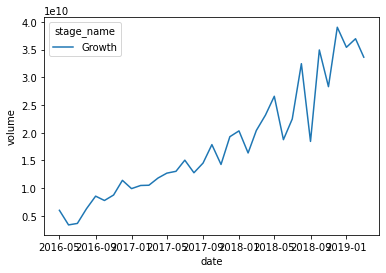

In [ ]:
sns.lineplot(x='date',y='volume',hue='stage_name', data=final_df_v2.loc[final_df_v2.cluster_id == 'ID_35'])

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      #Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 60
batch_size = 200

col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            'cluster',\
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'x1','x2','x3'\
            "last_stage_days"\
            ]
input = final_df_v2.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y ,
                   )
input.x1 = input.x1.fillna(0)
input.x2 = input.x2.fillna(0)
input.x3 = input.x3.fillna(0)

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(
    input, 
    train_balance = False, 
    val_balance = False, 
    col_drop = col_drop
    )

epochs = 200
batch_size = 500

history_test = mode_test.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data = (x_test, y_test))
predictions_test = mode_test.predict(x_test)
err_test = compute_error_validation(prediction_hang(predictions_test, y_test, val_df))
err_test.absolute_error.mean()
print(f'training set growth pct: {1 - y_train.sum() / y_train.shape[0]}')
print(f'test set growth pct:{1 - y_test.sum() / y_test.shape[0]}')
print(f'prediction growth pct: {1 - np.argmax(predictions_test, axis = 1).sum() / y_test.shape[0]}')
print(f"mean accurary: {np.mean(history_test.history['accuracy'])}")

In [ ]:
plot(history_test)

In [ ]:
err_test

In [ ]:
evaluate_validation(prediction_hang(predictions_test, y_test, val_df))

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 30
batch_size = 200

col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            'cluster',\
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'x1','x2','x3'\
            #"last_stage_days"\
            ]
input = final_df_v2.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y ,
                   )
input.x1 = input.x1.fillna(0)
input.x2 = input.x2.fillna(0)
input.x3 = input.x3.fillna(0)

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(
    input, 
    train_balance = False, 
    val_balance = False, 
    col_drop = col_drop
    )

n = 5

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

* More layers add more uncertainty. Adding epochs not helping

In [ ]:
#@title
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 100
batch_size = 200

col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            #'cluster',\
            #'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'x1','x2','x3'\
            #"last_stage_days"\
            ]
input = final_df_v2.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y ,
                   )
input.x1 = input.x1.fillna(0)
input.x2 = input.x2.fillna(0)
input.x3 = input.x3.fillna(0)

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(
    input, 
    train_balance = False, 
    val_balance = False, 
    col_drop = col_drop
    )

n = 5

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

* better when batch size decreased

In [ ]:
#@title
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 30
batch_size = 100

col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            #'cluster',\
            #'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'x1','x2','x3'\
            #"last_stage_days"\
            ]
input = final_df_v2.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y ,
                   )
input.x1 = input.x1.fillna(0)
input.x2 = input.x2.fillna(0)
input.x3 = input.x3.fillna(0)

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(
    input, 
    train_balance = False, 
    val_balance = False, 
    col_drop = col_drop
    )

n = 5

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

* By far, the best model

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      #Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 60
batch_size = 200

col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            'cluster',\
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'x1','x2','x3'\
            #"last_stage_days"\
            ]
input = final_df_v2.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y ,
                   )
input.x1 = input.x1.fillna(0)
input.x2 = input.x2.fillna(0)
input.x3 = input.x3.fillna(0)

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(
    input, 
    train_balance = False, 
    val_balance = False, 
    col_drop = col_drop
    )

n = 5

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

* small batches leads to small variance, but average performance is not better. 

In [ ]:
#@title
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      #Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 30
batch_size = 80

col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            'cluster',\
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'x1','x2','x3'\
            #"last_stage_days"\
            ]
input = final_df_v2.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y ,
                   )
input.x1 = input.x1.fillna(0)
input.x2 = input.x2.fillna(0)
input.x3 = input.x3.fillna(0)

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(
    input, 
    train_balance = False, 
    val_balance = False, 
    col_drop = col_drop
    )

n = 5

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

* Large batch size does not lead to better result. need to increase epoch number. 

In [ ]:
#@title
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      #tf.keras.layers.BatchNormalization(),
      Dense(128, activation = "relu"),
      #Dense(64, activation = "relu"),
      #Dense(32, activation = "relu"),
      #Dense(8, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# slightly higher when include month
# much higher after exclude last_stage_days

epochs = 30
batch_size = 800

col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date", \
            'cluster',\
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', \
            'vol_mean_alltime', 'vol_std_alltime',\
            'vol_mean_before_2016', 'vol_std_before_2016', 
            'vol_mean_before_4m','vol_std_before_4m', \
            'vol_mean_before_1y', 'vol_std_before_1y', \
            #'x1','x2','x3'\
            #"last_stage_days"\
            ]
input = final_df_v2.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y ,
                   )
input.x1 = input.x1.fillna(0)
input.x2 = input.x2.fillna(0)
input.x3 = input.x3.fillna(0)

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(
    input, 
    train_balance = False, 
    val_balance = False, 
    col_drop = col_drop
    )

n = 5

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

#### Model Selection

Model Improvement Below

* After test, 3 hidden layer is too much. 1 hidden layer can perform very well. 
* Small batches may cause unstable of the result 
* When model made 50/50 maturity and growth prediction, the result is bad due to the test set property
* Adding cluster would harm the result slightly
* Deeper model with more feature is better


In [ ]:
def model_avg(training_set, val_set, x_train, y_train, x_test, y_test, val_df, seeds, model, n = 5, epochs = 5, batch_size = 32):
  if seeds:
    seeds = []
    for i in range(n):
      seeds.append(random.randint(0,100))

  err = []
  for i in seeds:
    tf.keras.utils.set_random_seed(i)
    history_test = mode_test.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data = (x_test, y_test))
    predictions_test = mode_test.predict(x_test)
    err_test = compute_error_validation(prediction_hang(predictions_test, y_test, val_df))
    err.append(err_test.absolute_error.mean())
  return err

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      Dense(128, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
# 13.699 with last_stage_days and clusters
# 22.015 after include last_stage_days
training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False, col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date","last_stage_days"])
n = 5
epochs = 5
batch_size = 32

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      Dense(128, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False, col_drop = ["transition_point","stage_name_lag_1","stage_id_cumsum","volume","start_date","cluster"])
n = 5
epochs = 5
batch_size = 32

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      Dense(128, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      #loss = 'sparse_categorical_accuracy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)
n = 5
epochs = 30
batch_size = 32

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
tf.keras.utils.set_random_seed(1)

mode_test = tf.keras.models.Sequential([
      Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      #loss = 'sparse_categorical_accuracy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)
n = 5
epochs = 30
batch_size = 32

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      #loss = 'sparse_categorical_accuracy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)
n = 5
epochs = 30
batch_size = 400

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      #loss = 'sparse_categorical_accuracy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)
n = 5
epochs = 200
batch_size = 400

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      Dense(128, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      #loss = 'sparse_categorical_accuracy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)
n = 5
epochs = 200
batch_size = 400

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      Dense(64, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      #loss = 'sparse_categorical_accuracy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)
n = 5
epochs = 300
batch_size = 400

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = True,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
tf.keras.utils.set_random_seed(1234)

mode_test = tf.keras.models.Sequential([
      Dense(128, activation = "relu"),
      Dense(16, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      #loss = 'sparse_categorical_accuracy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)
n = 5
epochs = 200
batch_size = 400
seeds = True

result = model_avg(
    training_set =training_set, 
    val_set = val_set, 
    x_train = x_train, 
    y_train = y_train, 
    x_test = x_test, 
    y_test = y_test, 
    val_df = val_df, 
    seeds = seeds,
    n = n, 
    epochs = epochs, 
    batch_size = batch_size, 
    model = mode_test
                   )
print(result)
print(f'the average of the result is: {np.mean(result)}')

In [ ]:
mode_test = tf.keras.models.Sequential([
      Dense(128, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      #loss = 'sparse_categorical_accuracy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)

epochs = 200
batch_size = 500

history_test = mode_test.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data = (x_test, y_test))
predictions_test = mode_test.predict(x_test)
err_test = compute_error_validation(prediction_hang(predictions_test, y_test, val_df))
err_test.absolute_error.mean()
print(f'training set growth pct: {1 - y_train.sum() / y_train.shape[0]}')
print(f'test set growth pct:{1 - y_test.sum() / y_test.shape[0]}')
print(f'prediction growth pct: {1 - np.argmax(predictions_test, axis = 1).sum() / y_test.shape[0]}')
print(f"mean accurary: {np.mean(history_test.history['accuracy'])}")

In [ ]:
mode_test = tf.keras.models.Sequential([
      Dense(64, activation = "relu"),
      Dense(2, activation = "softmax")
  ])

mode_test.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      #loss = 'sparse_categorical_accuracy',
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)

epochs = 50
batch_size = 500

history_test = mode_test.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data = (x_test, y_test))
predictions_test = mode_test.predict(x_test)
err_test = compute_error_validation(prediction_hang(predictions_test, y_test, val_df))
err_test.absolute_error.mean()
print(f'training set growth pct: {1 - y_train.sum() / y_train.shape[0]}')
print(f'test set growth pct:{1 - y_test.sum() / y_test.shape[0]}')
print(f'prediction growth pct: {1 - np.argmax(predictions_test, axis = 1).sum() / y_test.shape[0]}')
print(f"mean accurary: {np.mean(history_test.history['accuracy'])}")

In [ ]:
plot(history_test)

In [ ]:
# ! pip install 'tensorflow_addons'

In [ ]:
tf.keras.utils.set_random_seed(1234)
mode_test = tf.keras.models.Sequential([
      Dense(64, activation = "relu"),
      Dense(32, activation = "relu"),
      Dense(16, activation = "relu"),
      Dense(1, activation = "sigmoid")
  ])

loss_fn = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma=2, from_logits=True)

mode_test.compile(
      optimizer='adam',
      loss = loss_fn,
      metrics=['accuracy']
  )

training_set, val_set, x_train, y_train, x_test, y_test, val_df = input_hang(final_df, train_balance = False, val_balance = False)

epochs = 20
batch_size = 128

history_test = mode_test.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0, validation_data = (x_test, y_test))
predictions_test = mode_test.predict(x_test)
err_test = compute_error_validation(prediction_hang(np.concatenate((1 - predictions_test, predictions_test), axis = 1), y_test, val_df))
err_test.absolute_error.mean()
print(f'training set growth pct: {1 - y_train.sum() / y_train.shape[0]}')
print(f'test set growth pct:{1 - y_test.sum() / y_test.shape[0]}')
print(f'prediction growth pct: {1 - predictions_test.sum() / y_test.shape[0]}')
print(f"mean accurary: {np.mean(history_test.history['accuracy'])}")

In [ ]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [0, 1, 0, 0]
y_pred = [-18.6, 0.51, 2.94, -12.8]
loss = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True, gamma=3, from_logits=True)
loss(y_true, y_pred, sample_weight=[0.8, 0.2]).numpy()


In [ ]:
predictions_test.sum()

In [ ]:
predictions_test[0]

https://amaarora.github.io/2020/06/29/FocalLoss.html#alpha-and-gamma

In [ ]:
from sklearn.preprocessing import LabelEncoder

Y = final_df.stage_name
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
pd.value_counts(encoded_Y)

In [ ]:
encoded_Y

In [ ]:
np.array(y_test)